In [31]:
import time
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier #ensemble=kümeleme,birleştirme

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [32]:
train_df= pd.read_csv("data/titanic_train.csv")

In [33]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [34]:
train_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [35]:
# Age (yaş) için eksik değerlerin oranı
train_df["Age"].isnull().sum() /train_df.shape[0]*100

19.865319865319865

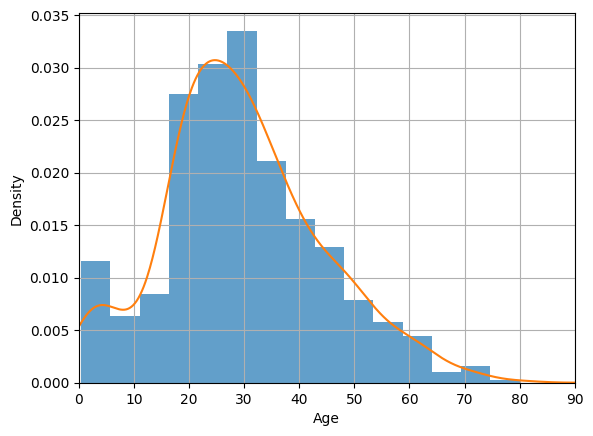

In [36]:
#Yolcuların yaklaşık %20'sinin yaş (Age) değerleri eksik
#grafikte bakalım
"""
bins=15: Bu, histogramda kaç çubuk (bin) olacağını belirtir. Burada 15 çubuk kullanılacak.

density=True: Bu, histogramın yoğunluk fonksiyonu olarak mı yoksa frekansla mı çizileceğini belirtir. True ise yoğunluk fonksiyonu olarak çizer.

stacked=True: Eğer birden fazla veri seti varsa, bu parametre onları üst üste binler. (yığılmış)

alpha=0.7: Bu, grafik elemanlarının (çubuklar, çizgiler vb.) opaklığını belirtir. Burada 0.7 değeri kullanılarak bir miktar saydamlık eklenir.
"""
ax=train_df["Age"].hist(bins=15, density=True, stacked=True, alpha=0.7)
train_df["Age"].plot(kind="density")
ax.set(xlabel="Age")
plt.xlim(0, 90)
plt.grid()
plt.show()

In [37]:
# mean -> ortalama
# skipna -> eksik verileri es geç (skip)

train_df["Age"].mean(skipna=True)

29.69911764705882

In [38]:
# median -> ortanca
train_df["Age"].median(skipna=True)

28.0

Burda Age sütununun mean ve median değerlerini aldık homojen dağılan bir data seti olmadığı için medianla gitmeye karar verdik

In [39]:
# Cabin için eksik değerler oranı
train_df["Cabin"].isnull().sum() / train_df.shape[0]* 100
#çok eksik olduğu için bunu çıkartacağız

77.10437710437711

In [40]:
# embarked (gemiye binme) için eksik değer oranı
train_df["Embarked"].isnull().sum() / train_df.shape[0]*100
#bunda eksik veri oranı 0.2 olduğu için bunu dolduracağız

0.22446689113355783

In [41]:
# yolcuların nereden bindikleri
print("Yolcuların hangi limandan bindikleri % olarak: (C= Cherbourg, Q = Queenstown, S = Southampton):")
print(train_df["Embarked"].value_counts() / train_df.shape[0]*100)

Yolcuların hangi limandan bindikleri % olarak: (C= Cherbourg, Q = Queenstown, S = Southampton):
Embarked
S    72.278339
C    18.855219
Q     8.641975
Name: count, dtype: float64


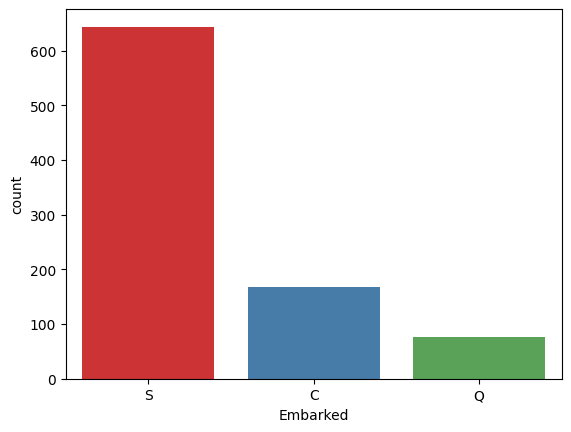

In [42]:
# grafik ile de görelim
sns.countplot(x="Embarked", data=train_df, palette="Set1")
plt.show()

In [43]:
# en fazla binilen limanı bulalım -> idxmax(), eksik değerleri en çok olanla dolduracağız.

print('En fazla binilen liman: ', train_df['Embarked'].value_counts().idxmax())

En fazla binilen liman:  S


In [44]:
train_data= train_df.copy()

In [45]:
# Age -> eksikleri median ile dolduralım -> fillna()
train_data["Age"].fillna(train_df["Age"].median(skipna=True), inplace=True)

In [46]:
# Embarked -> eksikleri 'S' ile dolduralım

train_data["Embarked"].fillna(train_df["Embarked"].value_counts().idxmax(), inplace=True)

In [47]:
# Cabin -> bu sütunu çıkaralım -> drop

train_data.drop("Cabin", axis=1, inplace=True)

In [48]:
# şimdi bu ayarlamalardan sonra train_data'da eksik veri var mı bakalım
train_data.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

**Fazladan olan (Gereksiz) Değişken Analizi**

Birbiri ile ilgili olan iki sütun var: SibSp, Parch

SibSp: # of siblings / spouses aboard the Titanic

çocuk adedi (çift, karı-koca, için)

Parch: # of parents / children aboard the Titanic

In [49]:
# SibSp ve Parch'a bakıp eğer ikisinin toplamı sıfır'dan büyükse o zaman yanlız seyahat etmiyordur -> 0
# eğer toplamları sıfır ise o zaman yanlız seyahat ediyordur -> 1
#sondaki 0,0,1 bir sırasıyla koşul, koşulu sağlayan ve sağlamayan değer 
train_data["YalnizSeyahat"]= np.where((train_data["SibSp"]+ train_data["Parch"])> 0,0,1)

In [50]:
# SibSp ve Parch sütunlarını atalım

train_data.drop("SibSp", axis=1, inplace=True)
train_data.drop("Parch", axis=1, inplace=True)

In [51]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,Ticket,Fare,Embarked,YalnizSeyahat
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,A/5 21171,7.2500,S,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,PC 17599,71.2833,C,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,STON/O2. 3101282,7.9250,S,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,113803,53.1000,S,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,373450,8.0500,S,1


**Kategorik Değişkenler**

In [52]:
# get_dummies() ile encode edelim
train_data= pd.get_dummies(train_data, columns=["Pclass","Embarked","Sex"],drop_first=True, dummy_na=False )

In [56]:
boolean_columns = ["YalnizSeyahat", "Pclass_2", "Pclass_3", "Embarked_Q", "Embarked_S", "Sex_male"]

# Belirtilen sütunları 1 ve 0'a dönüştür
train_data[boolean_columns] = train_data[boolean_columns].astype(int)


In [57]:
train_data.head()

,PassengerId,Survived,Name,Age,Ticket,Fare,YalnizSeyahat,Pclass_2,Pclass_3,Embarked_Q,Embarked_S,Sex_male
0,1,0,"Braund, Mr. Owen Harris",22.0,A/5 21171,7.2500,0,0,1,0,1,1
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,PC 17599,71.2833,0,0,0,0,0,0
2,3,1,"Heikkinen, Miss. Laina",26.0,STON/O2. 3101282,7.9250,1,0,1,0,1,0
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,113803,53.1000,0,0,0,0,1,0
4,5,0,"Allen, Mr. William Henry",35.0,373450,8.0500,1,0,1,0,1,1


In [60]:
#"PassengerId", "Name" ve "Ticket" sütunlarını atalım
train_data.drop("PassengerId", axis=1, inplace=True)
train_data.drop("Name", axis=1, inplace=True)
train_data.drop("Ticket", axis=1, inplace=True)

In [61]:
train_data.head()

,Survived,Age,Fare,YalnizSeyahat,Pclass_2,Pclass_3,Embarked_Q,Embarked_S,Sex_male
0,0,22.0,7.2500,0,0,1,0,1,1
1,1,38.0,71.2833,0,0,0,0,0,0
2,1,26.0,7.9250,1,0,1,0,1,0
3,1,35.0,53.1000,0,0,0,0,1,0
4,0,35.0,8.0500,1,0,1,0,1,1


**Exploratory Data Analysis (EDA) İŞLEMLERİ**

In [62]:
# train datanın şekli
train_data.shape

(891, 9)

In [64]:
# train data içindeki toplam veri adedi
print("train data içindeki toplam veri adedi: ",train_data.shape[0])

train data içindeki toplam veri adedi:  891


In [65]:
# sütun adları -> train
col_names= train_data.columns
col_names

Index(['Survived', 'Age', 'Fare', 'YalnizSeyahat', 'Pclass_2', 'Pclass_3',
       'Embarked_Q', 'Embarked_S', 'Sex_male'],
      dtype='object')

**AGE için EDA**

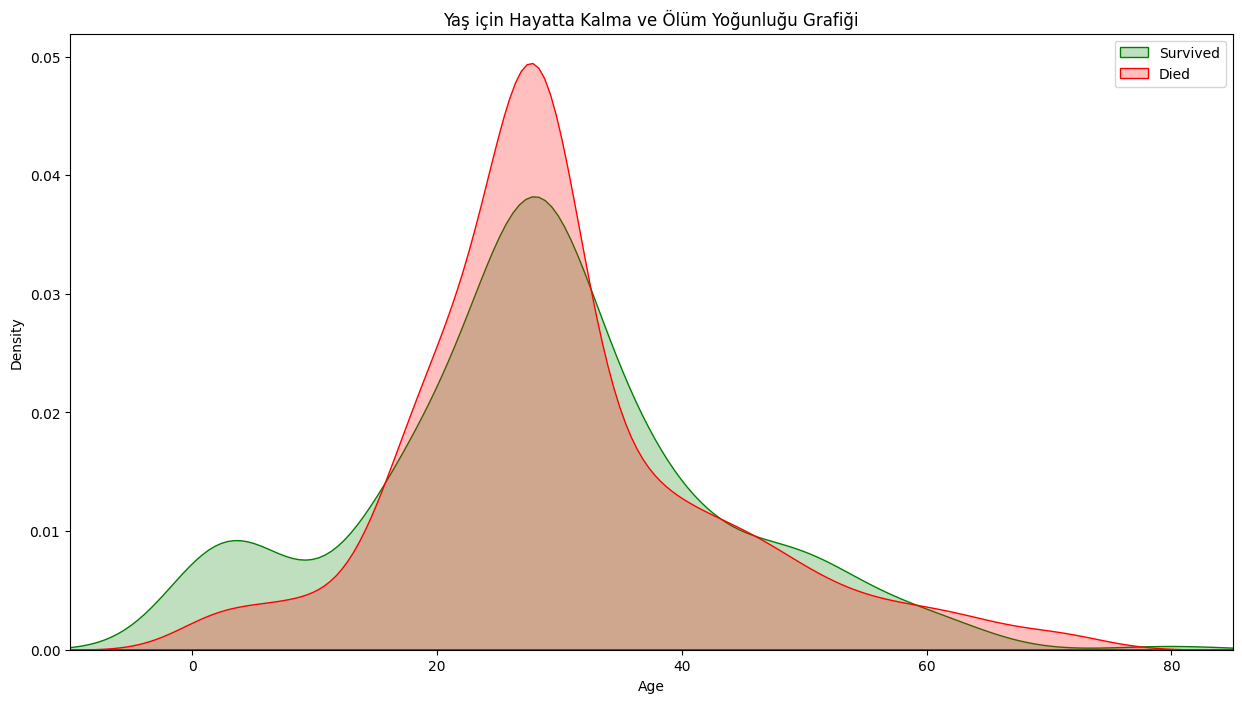

In [67]:
plt.figure(figsize=(15,8))

# Hayatta kalanlar -> Survived == 1
# https://seaborn.pydata.org/generated/seaborn.kdeplot.html
#kdeplot=çekirdek yoğunluk tahminlemesi (kernel density estimation),veri dağılımını görselleştirmek için kullanılır

#burada yaşayanları yeşil, ölenleri kırmızı ile gösterip kesişime bakacağız.
ax=sns.kdeplot(train_data["Age"][train_data.Survived==1],color="green",shade=True)
ax=sns.kdeplot(train_data["Age"][train_data.Survived==0],color="red",shade=True)

plt.legend(["Survived", "Died"])
plt.title("Yaş için Hayatta Kalma ve Ölüm Yoğunluğu Grafiği")
ax.set(xlabel="Age")
plt.xlim(-10,85)
plt.show()

**FARE (ÜCRET) için EDA**

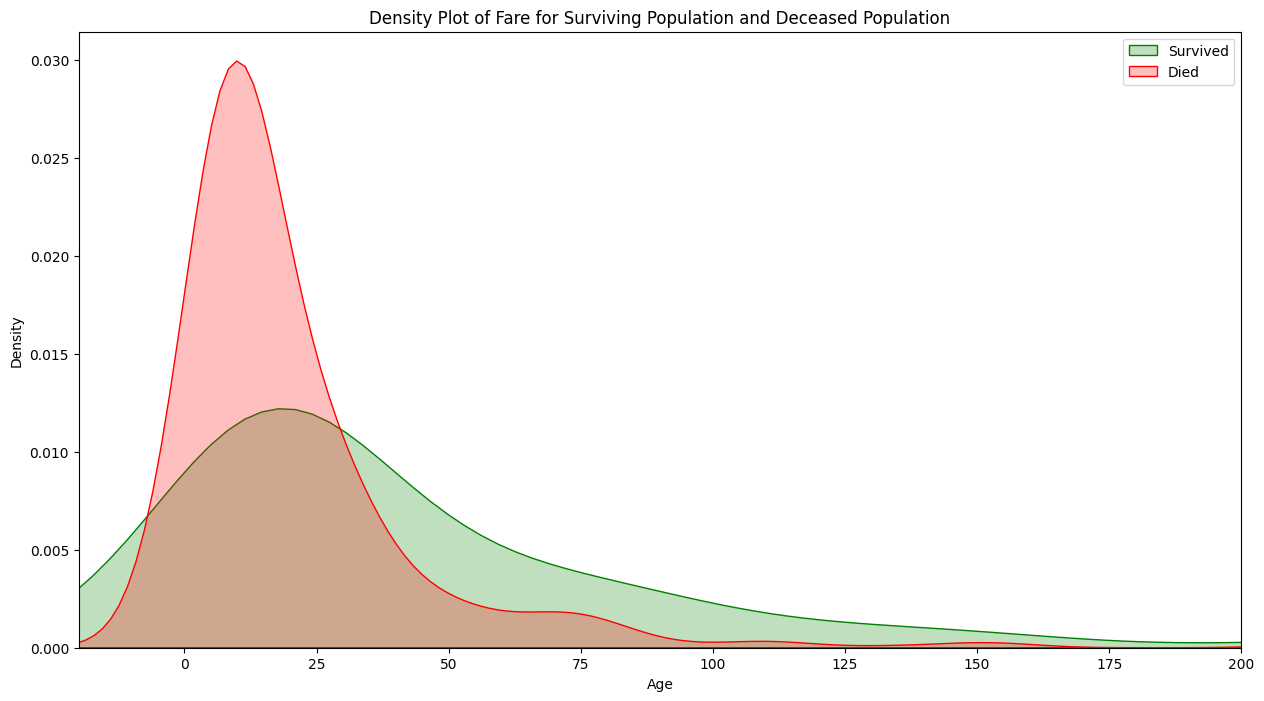

In [68]:
plt.figure(figsize=(15,8))
ax=sns.kdeplot(train_data["Fare"][train_data.Survived==1], color="green",shade=True)
ax=sns.kdeplot(train_data["Fare"][train_data.Survived==0], color="red",shade=True)
plt.legend(["Survived", "Died"])
plt.title("Density Plot of Fare for Surviving Population and Deceased Population")
ax.set(xlabel="Age")
plt.xlim(-20,200)
plt.show()

Ücret barriz fark oluşturuyor ve model tahminlemesinde önemli bir rol oynuyor.

**PASSENGER CLASS için EDA**

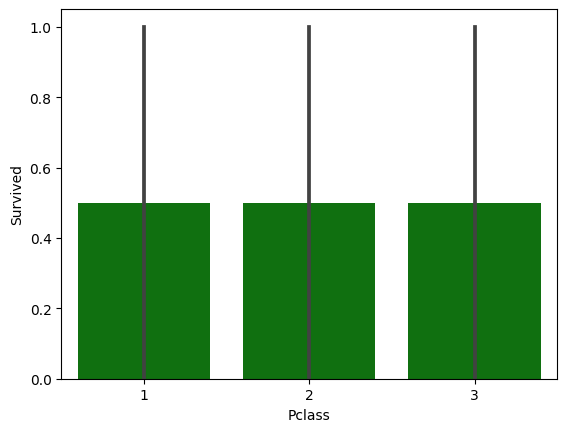

In [82]:
sns.barplot(x='Pclass', y='Survived', data=train_df, color="green", )

plt.show()

Burada grafik yanlış değerleri göstermektedir sırasıyla 1,2,3 şeklinde azalmaktadır. 

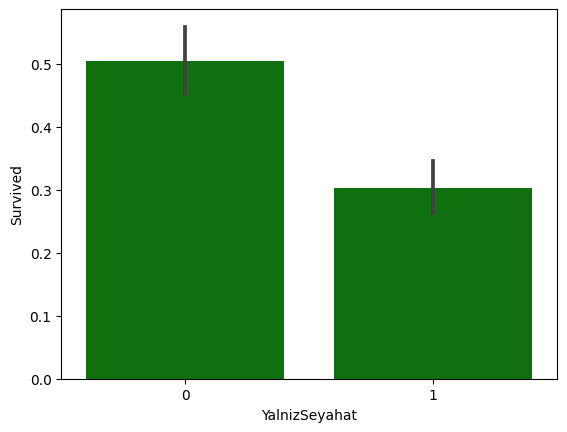

In [80]:
sns.barplot(x='YalnizSeyahat', y='Survived', data=train_data, color="green")

plt.show()

Passenger Class'ı yani Yolcu Sınıfı 1. sınıf olan yolcuların hayatta kalma oranları daha yüksek. Dolayısı ile bu da Ücret için yaptığımız varsayımı doğrular nitelikte.

**Aile ile veya Yalnız Seyahat için EDA**

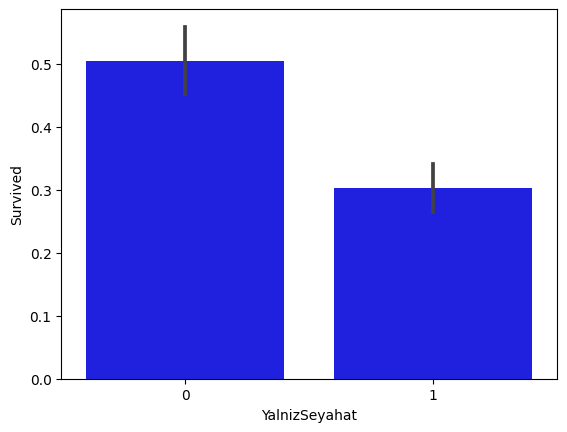

In [83]:
sns.barplot(x="YalnizSeyahat", y="Survived", data=train_data, color="blue")
plt.show()

**Input-Output Ayrımı**

In [94]:
y= train_data["Survived"]
train_data.drop("Survived",axis=1, inplace=True)

**Feature Scaling (Boyutlama)**

In [95]:
train_data.describe()

,Age,Fare,YalnizSeyahat,Pclass_2,Pclass_3,Embarked_Q,Embarked_S,Sex_male
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,29.361582,32.204208,0.602694,0.206510,0.551066,0.086420,0.725028,0.647587
std,13.019697,49.693429,0.489615,0.405028,0.497665,0.281141,0.446751,0.477990
min,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,22.000000,7.910400,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,28.000000,14.454200,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000
75%,35.000000,31.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000
max,80.000000,512.329200,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [96]:
cols=train_data.columns
cols

Index(['Age', 'Fare', 'YalnizSeyahat', 'Pclass_2', 'Pclass_3', 'Embarked_Q',
       'Embarked_S', 'Sex_male'],
      dtype='object')

In [97]:
scaler= MinMaxScaler()

# scaler'ı train data üzerinde eğitelim ve train datayı scale edelim
train_data=scaler.fit_transform(train_data)

In [98]:
type(train_data)

numpy.ndarray

In [99]:
# datayı DataFrame yapalım tekrar
train_data= pd.DataFrame(train_data,columns=[cols])

In [101]:
train_data.head()

,Age,Fare,YalnizSeyahat,Pclass_2,Pclass_3,Embarked_Q,Embarked_S,Sex_male
0,0.271174,0.014151,0.0,0.0,1.0,0.0,1.0,1.0
1,0.472229,0.139136,0.0,0.0,0.0,0.0,0.0,0.0
2,0.321438,0.015469,1.0,0.0,1.0,0.0,1.0,0.0
3,0.434531,0.103644,0.0,0.0,0.0,0.0,1.0,0.0
4,0.434531,0.015713,1.0,0.0,1.0,0.0,1.0,1.0


In [102]:
type(train_data)

pandas.core.frame.DataFrame

**Train-Test Split**

In [103]:
# datayı artık gerçek olarak train-test şeklinde ayırabiliriz
# test size: %20 ol
X_train, X_test, y_train, y_test = train_test_split(train_data,y, test_size=0.2,random_state=2)

In [104]:
X_train.shape

(712, 8)

In [105]:
X_test.shape

(179, 8)

**Model Oluşturma**

Önemli Hyperparameter'larımız şunlar:
1. **max_depth**: Decision Tree'lerin ne kadar derinliğe inecekleri (split sayısı)
2. **max_features**: Bir DT içinde split için kullanılacak maximum değişken sayısı
3. **criterion**: DT kriteri (gini, entropy)
4. **n_estimators**: Toplam yaratılacak DT sayısı

In [106]:
fit_rf= RandomForestClassifier(random_state=42)

Random_state parametresi, Random Forest algoritması veya diğer bazı rastgele süreçlere dayalı modellerin tekrarlanabilirliğini sağlamak amacıyla kullanılır. Bu parametre, algoritmanın içerisindeki rastgele süreçlere başlangıç değeri sağlar. Yani, aynı random_state değeri kullanıldığında, aynı başlangıç değeri elde edilir ve modelin aynı şekilde eğitilmesi sağlanır.

**Hyperparameter Optimization**


`GridSearchCV` kullanarak hyperparameter optimizasyonu yapacağız:

In [108]:
# random state için seed'i sabitle,aynı başlangıç değeri kullanıldığında, aynı rastgele sayı dizisi üretilir, bu da işlemlerin tekrar edilebilir olmasını sağlar.
np.random.seed(42)

# geçen süreyi hesaplamak için timer başlat
start=time.time()

# parametre grid'ini oluştur
param_dist={"max_depth":[2,3,4,],
          "n_estimators": [100,200,400], #Oluşturulacak olan ağaç sayısı.
          "max_features": ["auto","sqrt","log2",None], # Her bir bölünmede değerlendirilecek maksimum özellik sayısı.
          "criterion":["gini","entropy"]} #Bölünmeleri değerlendirmek için kullanılacak ölçü.

# n_jobs = 4 ile 4 paralel işlemci çalıştır
cv_rf= GridSearchCV(fit_rf, cv=5, param_grid=param_dist, n_jobs=4)

"""
n_jobs parametresi, GridSearchCV veya benzeri çapraz doğrulama (cross-validation) 
işlemlerinde paralel hesaplama yapmak için kullanılır. Bu parametre, aynı anda 
çalıştırılacak işlemci (CPU) sayısını belirtir. Yani, eğer bilgisayarınızda birden 
fazla işlemci çekirdeği varsa, bu parametre ile bu çekirdeklerin kullanılmasını sağlayabilir
ve hesaplama süresini azaltabilirsiniz.
"""

#cv_rf fit edelim
cv_rf.fit(X_train,y_train)

#en iyi parametreleri yazdır
print('GridSearch ile En İyi Parametreler: \n', cv_rf.best_params_)

# timer'ı bitir
end=time.time()

#süreyi yazdır
print('Grid Search için geçen zaman: {0: .2f}'.format(end - start))

GridSearch ile En İyi Parametreler: 
 {'criterion': 'entropy', 'max_depth': 4, 'max_features': 'log2', 'n_estimators': 200}
Grid Search için geçen zaman:  53.05


In [110]:
# GridSearch'ten aldığımız en iyi paramtreleri modelimize verelim

fit_rf.set_params(criterion="entropy",
                  max_features="log2",
                 max_depth=4,
                 n_estimators=200)

RandomForestClassifier(criterion='entropy', max_depth=4, max_features='log2',
                       n_estimators=200, random_state=42)

**Modeli Train Edelim**

In [111]:
fit_rf.fit(X_train,y_train)

RandomForestClassifier(criterion='entropy', max_depth=4, max_features='log2',
                       n_estimators=200, random_state=42)

**Değişkenlerin Önemini Bulma**

In [113]:
#hangi parametre hangi sırada önemli onu gösteriyor
pd.concat((pd.DataFrame(X_train.columns, columns = ['feature']), 
           pd.DataFrame(fit_rf.feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False) #Bu özellik önem sırasını yapıyor.

,feature,importance
7,"(Sex_male,)",0.478053
1,"(Fare,)",0.188794
4,"(Pclass_3,)",0.137478
0,"(Age,)",0.107912
2,"(YalnizSeyahat,)",0.027833
3,"(Pclass_2,)",0.023185
6,"(Embarked_S,)",0.022427
5,"(Embarked_Q,)",0.014319


**Tahmin**

In [115]:
# test data ile tahmin yap
y_pred= fit_rf.predict(X_test)
y_pred

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0], dtype=int64)

**Tahmin Kalitesini Ölçme**

In [116]:
#accuracy
print("Modelin Accuracy Score'u: {0:0.4f}".format(accuracy_score(y_test,y_pred)))

Modelin Accuracy Score'u: 0.7877


In [117]:
# classification report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.73      0.97      0.84       100
           1       0.94      0.56      0.70        79

    accuracy                           0.79       179
   macro avg       0.84      0.76      0.77       179
weighted avg       0.82      0.79      0.78       179

